In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import export_graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
import xgboost
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from copy import deepcopy
from sklearn.metrics import roc_auc_score, precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import scipy.stats as ss

In [62]:
#Load the balanced dataset 
dir1 = 'subsample_data'
data = pd.read_csv(dir1,header=0)

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (33,35,56) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [63]:
#Load the imbalanced dataset(ratio 1:16) for test
dir2 = 'test.csv'
test = pd.read_csv(dir2,header=0)

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (13,14,26,43,46,62,63,64,65,66,67,68,69,70,71,74,75,77,80,81,82,174,179) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [64]:
#Split the balanced datset into the targeted feature and predictive features
target = data['Target']
features = data.drop('Target', axis=1)

#Extract only numeric features from data
numerics = features._get_numeric_data()

#Extract categorical features and store the list of names of categorical features
categoricals = features.select_dtypes(include='object')

## Task 1: Identify Features 

In [65]:
#Check the number of missing values of numeric features
num = numerics.isnull().sum()
num

#Check the number of missing values of categorical features
categ = categoricals.isnull().sum()
categ

Unnamed: 0                                                             0
Physician_License_State_code2                                       9877
Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_5           9941
Recipient_State                                                       11
Recipient_Country                                                      7
Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1           1795
Form_of_Payment_or_Transfer_of_Value                                   0
Associated_Drug_or_Biological_NDC_4                                 9898
Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_4           9849
Covered_or_Noncovered_Indicator_3                                   9533
Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_5            9941
Physician_Specialty                                                 4802
Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_4            9849
Date_of_Payment                                    

In [66]:
#Check data info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 67 columns):
Unnamed: 0                                                          10000 non-null object
Unnamed: 1                                                          10000 non-null int64
Physician_License_State_code2                                       123 non-null object
Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_5           59 non-null object
Recipient_State                                                     9989 non-null object
Recipient_Country                                                   9993 non-null object
Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1           8205 non-null object
Form_of_Payment_or_Transfer_of_Value                                10000 non-null object
Associated_Drug_or_Biological_NDC_4                                 102 non-null object
Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_4           151 non-null object
Cover

/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


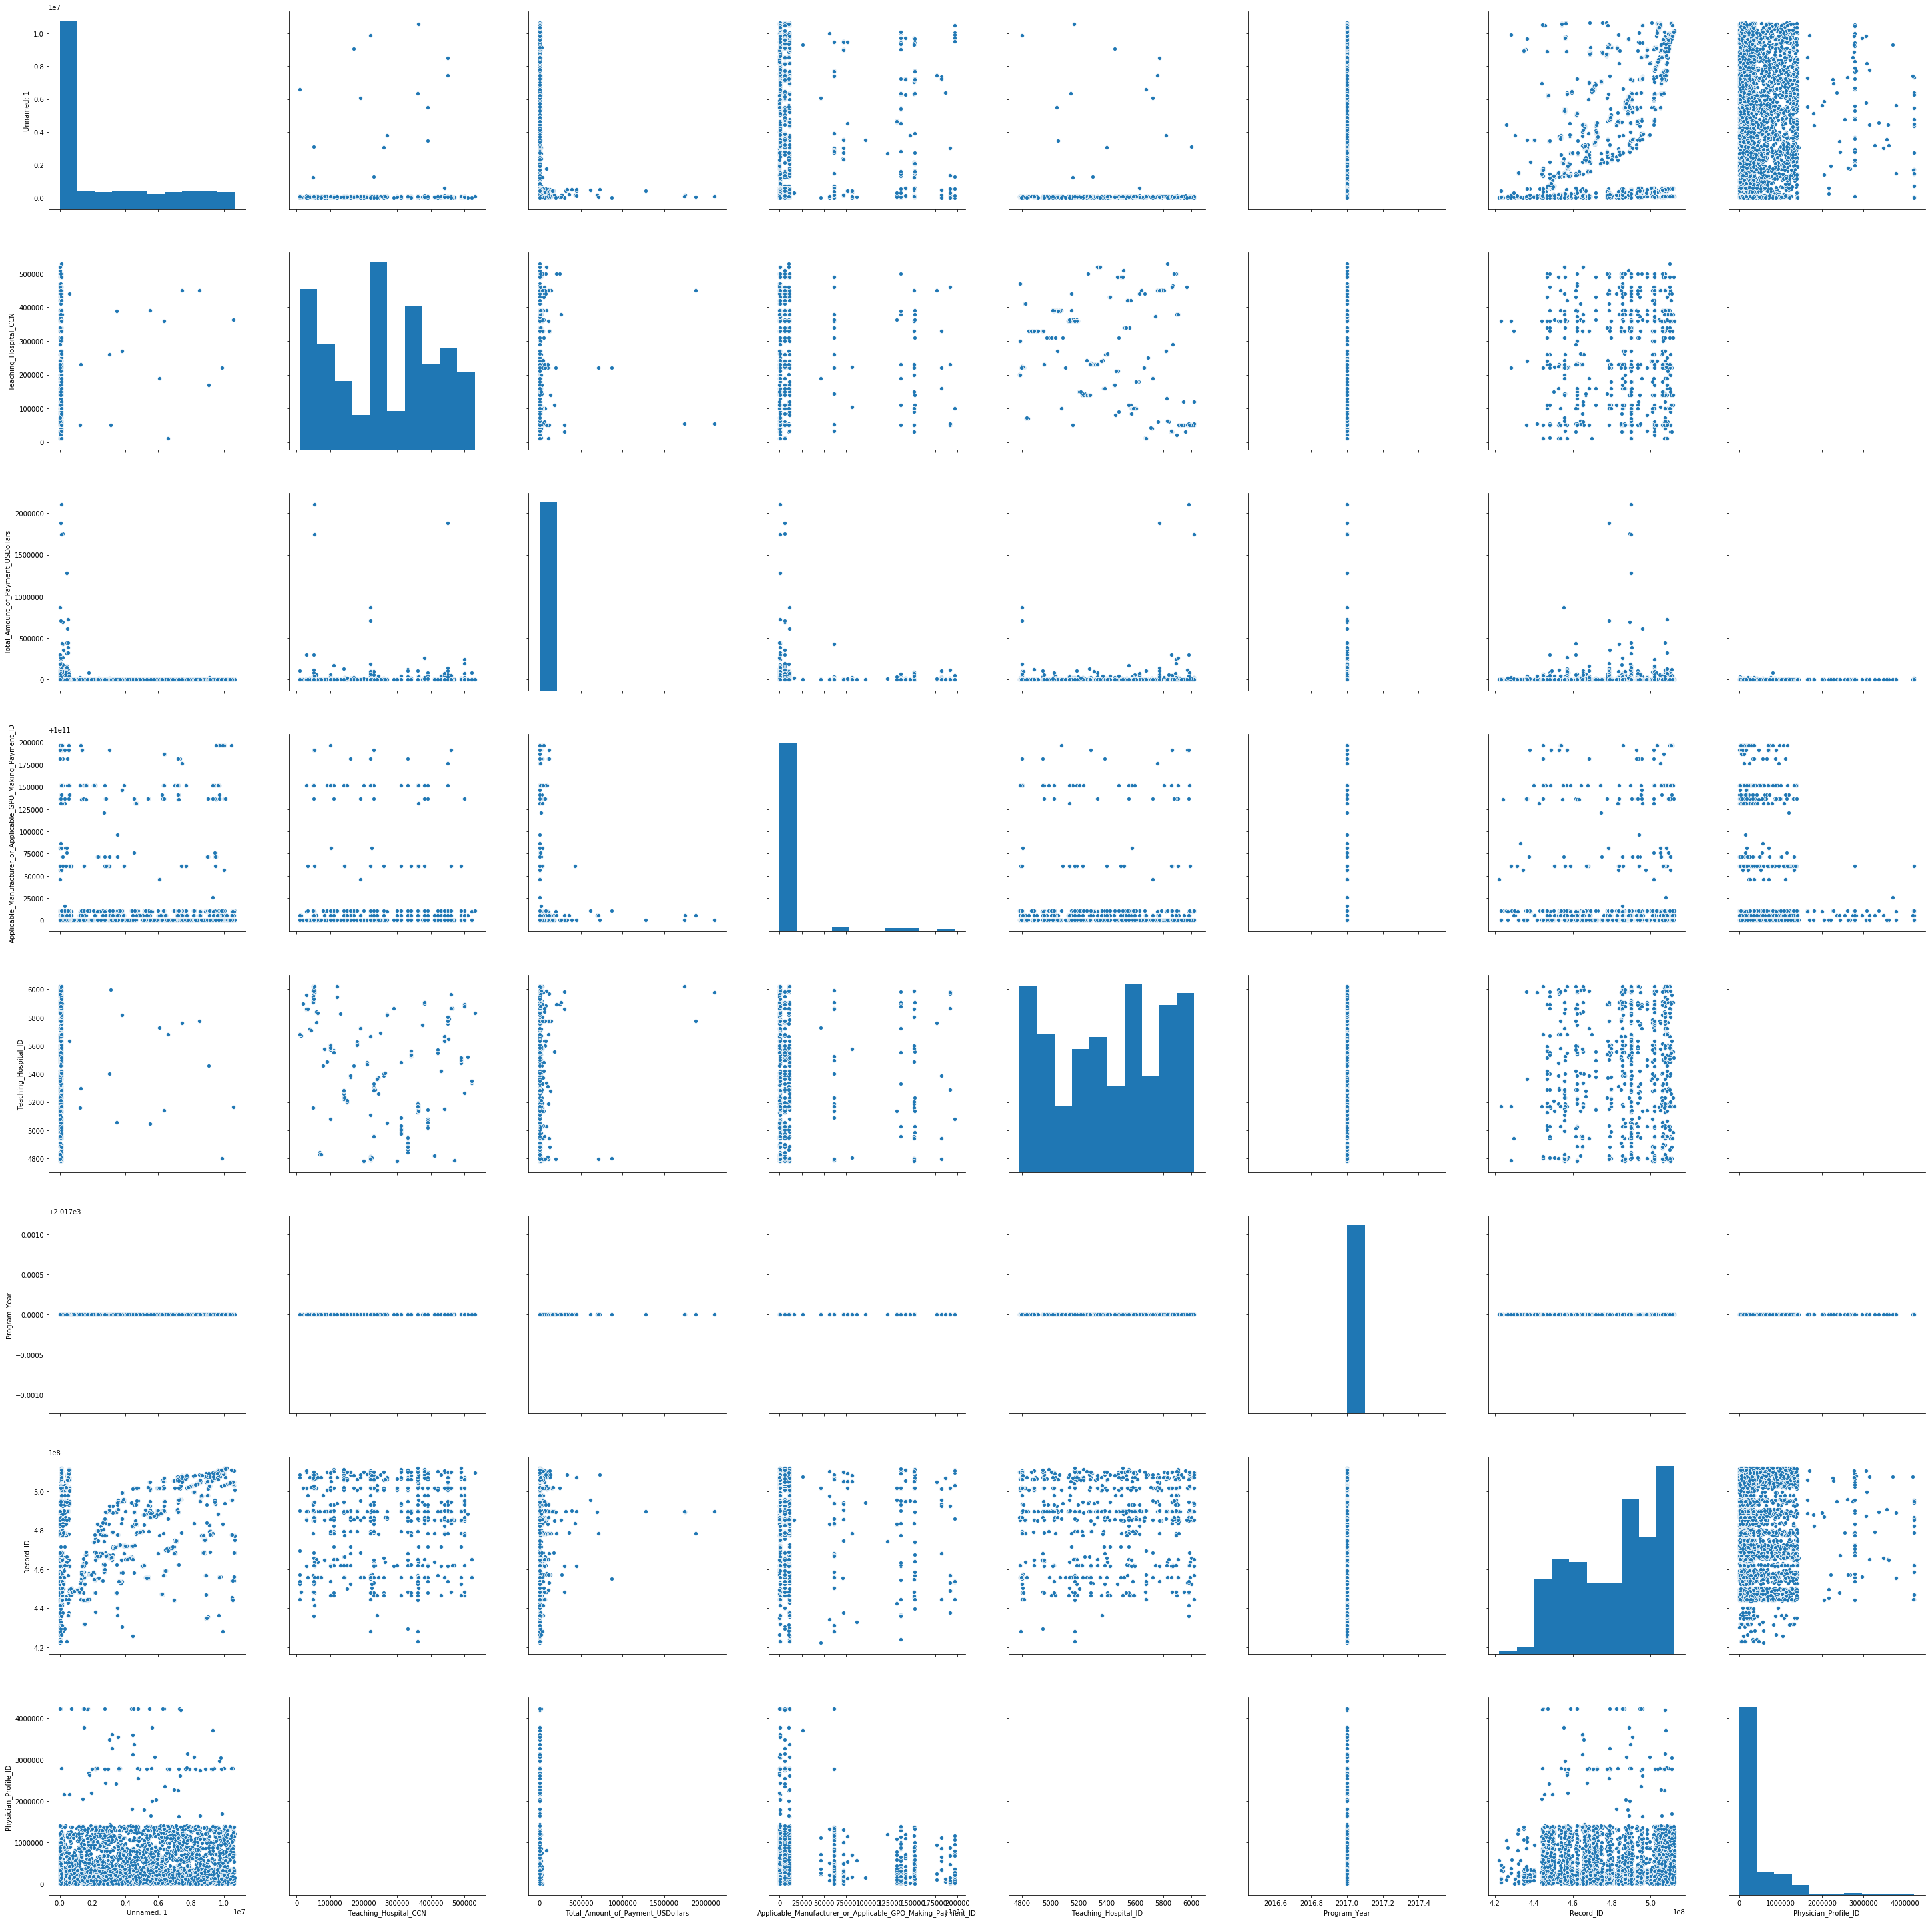

In [7]:
#Create a pairplot for numeric features to see how they are distributed
sns.pairplot(numerics,size=5)

## Preprocessing & Data Cleansing (For Balanced Data)

In [67]:
#Extract columns which have fewer than 5000 nulls
num_name = []
for i in range(len(num)):
    if(num[i-1] < 5000):
        num_name.append(num.index.tolist()[i-1])
    else:
        continue
num_name = ['Total_Amount_of_Payment_USDollars','Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID','Program_Year','Physician_Profile_ID']

#Create the dataframe for numeric variables , create a new dataframe named num_name, and store each variable's name   
temp = data[num_name]
num_temp = temp[['Total_Amount_of_Payment_USDollars']]
num_name = list(num_temp)
print('Numerical features with less than 50% nulls : ', num_name)

Numerical features with less than 50% nulls :  ['Total_Amount_of_Payment_USDollars']


In [68]:
#Store the list of names of numeric features
numeric_features = list(numerics)

#Store the list of names of categorical features
categorical_features = list(categoricals)

In [69]:
#Extract columns which have fewer than 5000 nulls
categ_name = []
for i in range(len(categ)):
    if(categ[i-1] < 5000):
        categ_name.append(categ.index.tolist()[i-1])
    else:
        continue

#Create the dataframe for categorical variables, create a new dataframe named categ_name, and store each variable's name   
categ_temp = data[categ_name]
categ_name = list(categ_temp)
print('Categorical features with less than 50% nulls : ', len(categ_name), categ_name)

Categorical features with less than 50% nulls :  28 ['Unnamed: 0', 'Recipient_State', 'Recipient_Country', 'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1', 'Form_of_Payment_or_Transfer_of_Value', 'Physician_Specialty', 'Date_of_Payment', 'Recipient_City', 'Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name', 'Related_Product_Indicator', 'Dispute_Status_for_Publication', 'Recipient_Primary_Business_Street_Address_Line1', 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country', 'Delay_in_Publication_Indicator', 'Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1', 'Physician_First_Name', 'Change_Type', 'Payment_Publication_Date', 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State', 'Recipient_Zip_Code', 'Physician_Primary_Type', 'Physician_License_State_code1', 'Physician_Last_Name', 'Associated_Drug_or_Biological_NDC_1', 'Covered_Recipient_Type', 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name', 'Product_Category_or_Therape

In [70]:
# Categories with high dimensional one hot vectors
remove_categories = []
for a in categ_name:
    if len(data[a].unique()) > 100:
        remove_categories.append(a)
print(remove_categories)

['Physician_Specialty', 'Date_of_Payment', 'Recipient_City', 'Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name', 'Recipient_Primary_Business_Street_Address_Line1', 'Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1', 'Physician_First_Name', 'Recipient_Zip_Code', 'Physician_Last_Name', 'Associated_Drug_or_Biological_NDC_1', 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name', 'Product_Category_or_Therapeutic_Area_1']


In [71]:
# Analysis of correlation between target and each categorical feature
from copy import deepcopy
categ_name_copy1 = deepcopy(categ_name)
print(categ_name)
new = pd.concat([num_temp,categ_temp],axis=1)
print("Baseline Logistic Regression for :")
for c in categ_name_copy1:
    categ_name1 = [c]
    #Build a pipeline to handle the numeric features
    numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                        ('scaler', StandardScaler())])

    #Build a pipeline to handle the categorical features
    categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                           ('onehot',OneHotEncoder(handle_unknown='ignore'))])

    #Build a column transformer to apply transformers above to the given dataset
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, num_name),
            ('cat', categorical_transformer, categ_name1)])

    #Create a pipeline which contains our model
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier',LogisticRegression(solver='lbfgs'))])

    #Split the dataset into the training set and test set
    X_train, X_test, y_train, y_test = train_test_split(new, target, stratify=target, test_size=0.3)

    #Cross validation 
    scores = cross_val_score(clf,X_train, y_train, cv=5)
    scores = sum(scores) / float(len(scores))
    print(c,scores)

categ_name = deepcopy(categ_name_copy1)

['Unnamed: 0', 'Recipient_State', 'Recipient_Country', 'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1', 'Form_of_Payment_or_Transfer_of_Value', 'Physician_Specialty', 'Date_of_Payment', 'Recipient_City', 'Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name', 'Related_Product_Indicator', 'Dispute_Status_for_Publication', 'Recipient_Primary_Business_Street_Address_Line1', 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country', 'Delay_in_Publication_Indicator', 'Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1', 'Physician_First_Name', 'Change_Type', 'Payment_Publication_Date', 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State', 'Recipient_Zip_Code', 'Physician_Primary_Type', 'Physician_License_State_code1', 'Physician_Last_Name', 'Associated_Drug_or_Biological_NDC_1', 'Covered_Recipient_Type', 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name', 'Product_Category_or_Therapeutic_Area_1', 'Covered_or_Noncovered_Indicator_1']
B

In [72]:
#Concatenate num_temp and categ_temp
new = pd.concat([num_temp,categ_temp],axis=1)

In [73]:
#Remove meaningless features
irrelavant = ['Unnamed: 0','Physician_Specialty','Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name',
    'Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1','Physician_First_Name','Physician_Primary_Type',
            'Physician_License_State_code1','Physician_Last_Name','Associated_Drug_or_Biological_NDC_1','Covered_Recipient_Type',
            'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name', 'Product_Category_or_Therapeutic_Area_1']
rec_details = ['Recipient_City','Recipient_Primary_Business_Street_Address_Line1','Recipient_Zip_Code']
new_remove = ['Date_of_Payment','Payment_Publication_Date','Delay_in_Publication_Indicator']
num_name = ['Total_Amount_of_Payment_USDollars']
categ_name_copy = deepcopy(categ_name)
remove_list = irrelavant + new_remove + rec_details
for a in remove_list:
    if a in categ_name_copy:
        categ_name_copy.remove(a)
(categ_name_copy)

['Recipient_State',
 'Recipient_Country',
 'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1',
 'Form_of_Payment_or_Transfer_of_Value',
 'Related_Product_Indicator',
 'Dispute_Status_for_Publication',
 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country',
 'Change_Type',
 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State',
 'Covered_or_Noncovered_Indicator_1']

In [55]:
#Reference: https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
def cramers_v(x, y):

    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))


In [58]:
columns = categ_temp.columns
cell = np.zeros(shape=(len(columns),len(columns)))

for i in range(0,len(columns)):
    for j in range(0,len(columns)):
        if i == j:
            cell[i][j] = categ_temp[columns[i]][columns[j]] = 1.0            
            
            j +=1
            
        else:
            cell[i][j] = cramers_v(categ_temp[columns[i]],categ_temp[columns[j]]) 
            
            j +=1


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:915: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc[key] = value
/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3267: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/inde

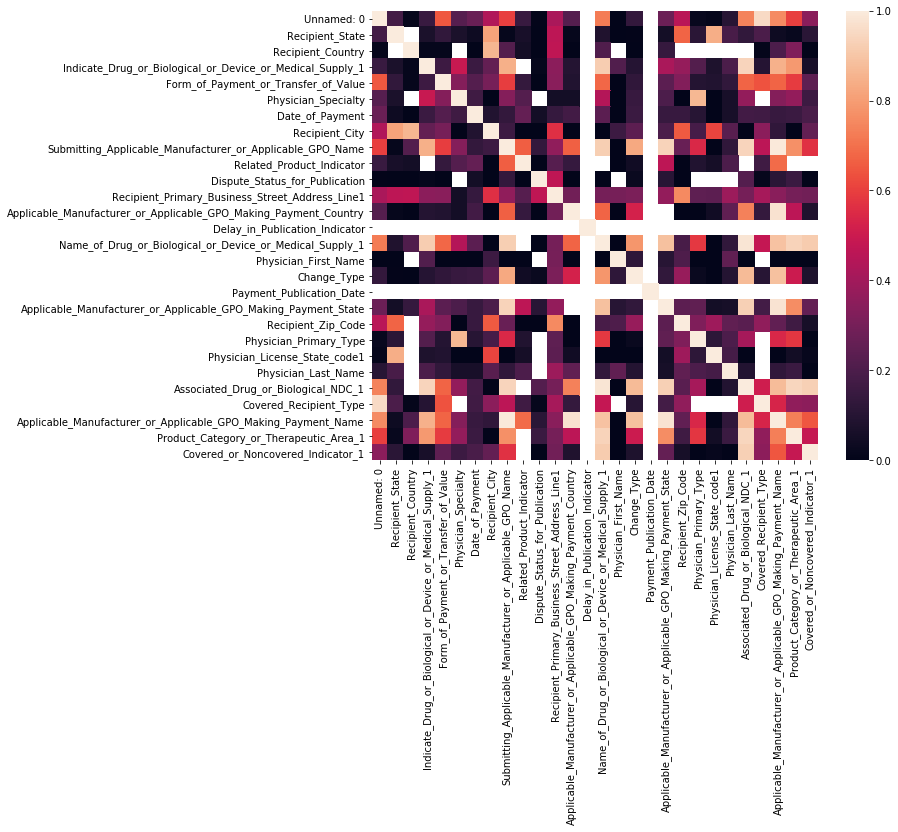

In [59]:
cell_df = pd.DataFrame(cell,index=columns, columns=columns)
size = (10, 8.27)
fig, ax = plt.subplots(figsize=size)
sns.heatmap(cell_df)


In [82]:
new_df = pd.concat([categ_temp,target],axis=1)
columns = new_df.columns
cell = np.zeros(shape=(len(columns),len(columns)))

for i in range(0,len(columns)):
    for j in range(0,len(columns)):
        if i == j:
            cell[i][j] = new_df[columns[i]][columns[j]] = 1.0            
            
            j +=1
            
        else:
            cell[i][j] = cramers_v(new_df[columns[i]],new_df[columns[j]]) 
            
            j +=1


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


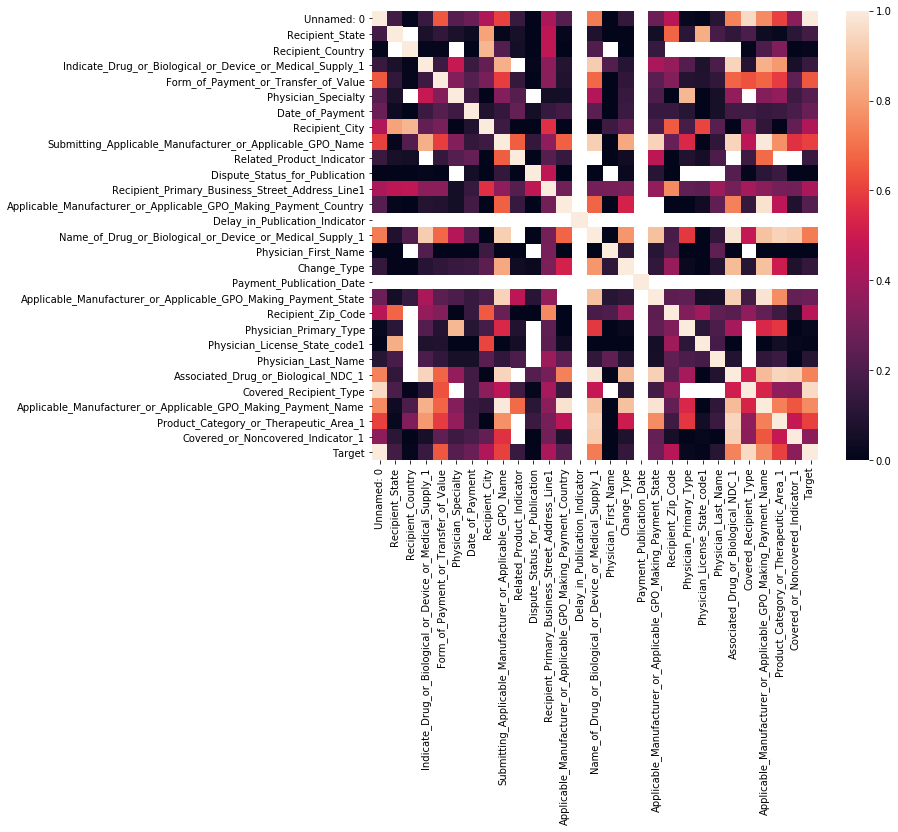

In [83]:
cell_df = pd.DataFrame(cell,index=columns, columns=columns)
size = (10, 8.27)
fig, ax = plt.subplots(figsize=size)
sns.heatmap(cell_df)


We categorized the features as numeric and categorical features and removed features based on the following :

* As the first level of screening, we checked which features have more than 5000 rows (50% of the data) as NULL and retained the remaining.
    * Numerical features : we were left with just 1 feature (Total_Amount_of_Payment_USDollars)
    * Categorical features : we were left with 28 features (stored in the list categ_name)

* From the heat map for the categorical features, we can see that, features like Payment_Publication_Date and Delay_in Publication_Indicator are highly correlated to the other features and thus, we can exclude them

* Among the features left, we analyzed highly correlated features by training Logistic regression for each of the feature separately.
    * We then removed the ones that were highly correlated to the target. 
    * The features are stored in the list irrelavant
    
* Among the remaining categorical features, we found that some of the features result in a very big one-hot encoded vector and they do not logically contribute to the model as well (eg: Recipient_Primary_Business_Street_Address_Line1, Date_of_Payment, Recipient_Zip_Code, Recipient_City), and we removed these features as well.


Finally, we ended up with 10 features.
 'Recipient_State',
 'Recipient_Country',
 'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1',
 'Form_of_Payment_or_Transfer_of_Value',
 'Related_Product_Indicator',
 'Dispute_Status_for_Publication',
 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country',
 'Change_Type',
 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State',
 'Covered_or_Noncovered_Indicator_1'
 
Similarly, for imbalanced data.

## Preprocessing & Data Cleansing (For Imbalanced Data)

In [74]:
#Split the balanced datset into the targeted feature and predictive features
imb_target = test['Target']
imb_features = test.drop('Target', axis=1)

#Extract only numeric features from data
imb_numerics = imb_features._get_numeric_data()

#Extract categorical features and store the list of names of categorical features
imb_categoricals = imb_features.select_dtypes(include='object')

In [75]:
#Check the number of missing values of numeric features
imb_num = imb_numerics.isnull().sum()

#Check the number of missing values of categorical features
imb_categ = imb_categoricals.isnull().sum()

In [76]:
#Extract columns which have fewer than 5000 nulls
imb_num_name = []
for i in range(len(imb_num)):
    if(imb_num[i-1] < 5000):
        imb_num_name.append(imb_num.index.tolist()[i-1])
    else:
        continue
imb_num_name = ['Total_Amount_of_Payment_USDollars','Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID','Program_Year','Physician_Profile_ID']

#Create the dataframe for numeric variables , create a new dataframe named num_name, and store each variable's name   
imb_temp = test[imb_num_name]
imb_num_temp = imb_temp[['Total_Amount_of_Payment_USDollars']]
imb_num_name = list(imb_num_temp)

In [77]:
#Store the list of names of numeric features
imb_numeric_features = list(imb_numerics)

#Store the list of names of categorical features
imb_categorical_features = list(imb_categoricals)

In [78]:
#Extract columns which have fewer than 5000 nulls
imb_categ_name = []
for i in range(len(imb_categ)):
    if(imb_categ[i-1] < 5000):
        imb_categ_name.append(imb_categ.index.tolist()[i-1])
    else:
        continue

#Create the dataframe for categorical variables, create a new dataframe named categ_name, and store each variable's name   
imb_categ_temp = test[imb_categ_name]
imb_categ_name = list(imb_categ_temp)

In [79]:
#Concatenate num_temp and categ_temp
new_new = pd.concat([imb_num_temp,imb_categ_temp],axis=1)

## Task 2: Baseline Model (Logistic Regression)

We used a logistic regression model for baseline as it is a linear model and is quite robust.

Preprocessing:
- For numerical features, we imputed the missing values using Median imputer and scaled the data for regression.
- For categorical features, we imputed the data and did a one-hot encoding to make it trainable in a logistic regression model
    

In [80]:
#Build a pipeline to handle the numeric features
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                        ('scaler', StandardScaler())])

#Build a pipeline to handle the categorical features
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                       ('onehot',OneHotEncoder(handle_unknown='ignore'))])

#Build a column transformer to apply transformers above to the given dataset
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_name),
        ('cat', categorical_transformer, categ_name_copy)])

#Create a pipeline which contains our model
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(C=0.01))])

#Split the dataset into the training set and test set
X_train, X_test, y_train, y_test = train_test_split(new, target, stratify=target, test_size=0.3)


#Cross validation 
scores = cross_val_score(clf,X_train, y_train, cv=10)
scores = sum(scores) / float(len(scores))
print("Baseline Model Cross Validation Score:")
print(scores)



Baseline Model Cross Validation Score:
0.8525714285714286


## Task 3: Feature Engineering

In [60]:
from sklearn.preprocessing import PolynomialFeatures
print(categ_name_copy)
#Build a pipeline to handle the numeric features
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                        ('scaler', StandardScaler())])

#Build a pipeline to handle the categorical features
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                       ('onehot',OneHotEncoder(handle_unknown='ignore'))])

#Build a column transformer to apply transformers above to the given dataset
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_name),
        ('cat', categorical_transformer, categ_name_copy)])

#Create a pipeline which contains our model
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('polynomial_features',PolynomialFeatures(degree=3)),
                      ('classifier', LogisticRegression(C=0.01))])

#Split the dataset into the training set and test set
X_train, X_test, y_train, y_test = train_test_split(new, target, stratify=target, test_size=0.3)


#Cross validation 
scores = cross_val_score(clf,X_train, y_train, cv=10)
scores = sum(scores) / float(len(scores))
print("Score with polynomial features:")
print(scores)



['Recipient_State', 'Recipient_Country', 'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1', 'Form_of_Payment_or_Transfer_of_Value', 'Related_Product_Indicator', 'Dispute_Status_for_Publication', 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country', 'Delay_in_Publication_Indicator', 'Change_Type', 'Payment_Publication_Date', 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State', 'Covered_or_Noncovered_Indicator_1']


KeyboardInterrupt: 

With polynomial features, the model overfits. Since, the baseline logistic regression model works pretty well, combining features does not seem to be relevant for the given task.

## Task 4: Any model

**Logistic Regression with GridSearch**

In [81]:
#Build a pipeline to handle the numeric features
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                        ('scaler', StandardScaler())])

#Build a pipeline to handle the categorical features
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                       ('onehot',OneHotEncoder(handle_unknown='ignore'))])

#Build a column transformer to apply transformers above to the given dataset
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_name),
        ('cat', categorical_transformer, categ_name_copy)])

#Create a pipeline which contains our model
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])

#Split the dataset into the training set and test set
X_train, X_test, y_train, y_test = train_test_split(new, target, stratify=target, test_size=0.3)

param_grid = {'classifier__C': [0.01,0.1, 1, 10, 100]}

logistic_grid = GridSearchCV(clf, param_grid=param_grid, cv=5)
logistic_grid.fit(X_train, y_train)

print("best mean cross-validation score of Logistic Regression: {:.3f}".format(logistic_grid.best_score_))
print("best parameters of Logistic Regression: {}".format(logistic_grid.best_params_))
print("test-set score of Logistic Regression: {:.3f}".format(logistic_grid.score(X_test, y_test)))
print("")

logistic = LogisticRegression(C=logistic_grid.best_params_['classifier__C'])
final_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', logistic)])
final_pipe.fit(X_train, y_train)
y_pred = final_pipe.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Metrix:")
print(cm)
print("")
print("ROC AUC score:" )
print(roc_auc_score(y_test, y_pred))
print("")
print("Precision Score:")
print(precision_score(y_test, y_pred))
print("")
print("Recall Score:")
print(recall_score(y_test, y_pred, average='weighted'))

best mean cross-validation score of Logistic Regression: 0.896
best parameters of Logistic Regression: {'classifier__C': 100}
test-set score of Logistic Regression: 0.895

Confusion Metrix:
[[1345  155]
 [ 159 1341]]

ROC AUC score:
0.8953333333333334

Precision Score:
0.8963903743315508

Recall Score:
0.8953333333333333


##### TRAIN THE BEST MODEL ON THE BALANCED TRAINING DATA SET WITH THE BEST PARAMS AGAIN AND TEST ON IMBALANCED DATASET


In [84]:
# TRAIN THE BEST MODEL ON THE BALANCED TRAINING DATA SET WITH THE BEST PARAMS AGAIN AND TEST ON IMBALANCED DATASET

#Build a pipeline to handle the numeric features
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                        ('scaler', StandardScaler())])

#Build a pipeline to handle the categorical features
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                       ('onehot',OneHotEncoder(handle_unknown='ignore'))])

#Build a column transformer to apply transformers above to the given dataset
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_name),
        ('cat', categorical_transformer, categ_name_copy)])

#Create a pipeline which contains our model
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(C=logistic_grid.best_params_['classifier__C']))])

clf.fit(features,target)

#Test the modeld with the imbalanced dataset to check its performance
y_pred = clf.predict(new_new)
cm = confusion_matrix(imb_target, y_pred)
print("Confusion Metrix:")
print(cm)
print("")
print("ROC AUC score:" )
print(roc_auc_score(imb_target, y_pred))
print("")
print("Precision Score:")
print(average_precision_score(imb_target, y_pred, average='weighted'))
print("")
print("Recall Score:")
print(recall_score(imb_target, y_pred, average='weighted'))


Confusion Metrix:
[[8323 1121]
 [  59  497]]

ROC AUC score:
0.8875925942854357

Precision Score:
0.28047403669153675

Recall Score:
0.882


**Ridge Regression with GridSearch**

In [85]:
#Build a pipeline to handle the numeric features
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                        ('scaler', StandardScaler())])

#Build a pipeline to handle the categorical features
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                       ('onehot',OneHotEncoder(handle_unknown='ignore'))])

#Build a column transformer to apply transformers above to the given dataset
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_name),
        ('cat', categorical_transformer, categ_name_copy)])

#Create a pipeline which contains our model
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RidgeClassifier())])

#Split the dataset into the training set and test set
X_train, X_test, y_train, y_test = train_test_split(new, target, stratify=target, test_size=0.3)

param_grid = {'classifier__alpha': [0.01,0.1, 1, 10, 100]}
ridge_grid = GridSearchCV(clf, param_grid=param_grid, cv=5)
ridge_grid.fit(X_train, y_train)

print("best mean cross-validation score of Ridge Regression: {:.3f}".format(ridge_grid.best_score_))
print("best parameters of Ridge Regression: {}".format(ridge_grid.best_params_))
print("test-set score of Ridge Regression: {:.3f}".format(ridge_grid.score(X_test, y_test)))
print("")

ridge = RidgeClassifier(alpha=ridge_grid.best_params_['classifier__alpha'])
final_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', ridge)])
final_pipe.fit(X_train, y_train)
y_pred = final_pipe.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Metrix:")
print(cm)
print("")
print("ROC AUC score:" )
print(roc_auc_score(y_test, y_pred))
print("")
print("Precision Score:")
print(precision_score(y_test, y_pred))
print("")
print("Recall Score:")
print(recall_score(y_test, y_pred, average='weighted'))

best mean cross-validation score of Ridge Regression: 0.875
best parameters of Ridge Regression: {'classifier__alpha': 0.01}
test-set score of Ridge Regression: 0.864

Confusion Metrix:
[[1301  199]
 [ 210 1290]]

ROC AUC score:
0.8636666666666666

Precision Score:
0.8663532572196104

Recall Score:
0.8636666666666667


##### TRAIN THE BEST MODEL ON THE BALANCED TRAINING DATA SET WITH THE BEST PARAMS AGAIN AND TEST ON IMBALANCED DATASET


In [86]:
#Build a pipeline to handle the numeric features
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                        ('scaler', StandardScaler())])

#Build a pipeline to handle the categorical features
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                       ('onehot',OneHotEncoder(handle_unknown='ignore'))])

#Build a column transformer to apply transformers above to the given dataset
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_name),
        ('cat', categorical_transformer, categ_name_copy)])

#Create a pipeline which contains our model
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RidgeClassifier(alpha=ridge_grid.best_params_['classifier__alpha']))])

clf.fit(features,target)

#Test the modeld with the imbalanced dataset to check its performance
y_pred = clf.predict(new_new)
cm = confusion_matrix(imb_target, y_pred)
print("Confusion Metrix:")
print(cm)
print("")
print("ROC AUC score:" )
print(roc_auc_score(imb_target, y_pred))
print("")
print("Precision Score:")
print(average_precision_score(imb_target, y_pred, average='weighted'))
print("")
print("Recall Score:")
print(recall_score(imb_target, y_pred, average='weighted'))

Confusion Metrix:
[[8166 1278]
 [  65  491]]

ROC AUC score:
0.8738847549660399

Precision Score:
0.25160962174296736

Recall Score:
0.8657


**Random Forest with GridSearch**

In [89]:
#Split the dataset into the training set and the test set
X_train, X_test, y_train, y_test = train_test_split(features, target, stratify=target, test_size=0.3,shuffle=True)

#Build a pipeline to handle the numeric features
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),
                    ('scaler', StandardScaler())])

#Build a pipeline to handle the categorical features
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                       ('onehot',OneHotEncoder(handle_unknown='ignore'))])

#Build a column transformer to apply transformers above to given dataset
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_name),
        ('cat', categorical_transformer, categ_name_copy)])

param_grid = {'classifier__max_depth' : range(1,10)}

#Create a pipeline which contains our model
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(warm_start=True))])

grid = GridSearchCV(clf, param_grid,cv=10, scoring='roc_auc')
grid.fit(X_train, y_train)

print('Score', grid.best_score_)
print('Best params',grid.best_params_)


rfc = RandomForestClassifier(n_estimators=200,
                               max_depth=grid.best_params_['classifier__max_depth'],random_state=0)
final_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', rfc)])
final_pipe.fit(X_train, y_train)
y_pred = final_pipe.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(roc_auc_score(y_test, y_pred))
print("")
print("Precision Score:")
print(precision_score(y_test, y_pred))
print("")
print("Recall Score:")
print(recall_score(y_test, y_pred, average='weighted'))

Score 0.9675881632653062
Best params {'classifier__max_depth': 9}
[[1374  126]
 [  77 1423]]
0.9323333333333333

Precision Score:
0.9186571981923822

Recall Score:
0.9323333333333333


##### TRAIN THE BEST MODEL ON THE BALANCED TRAINING DATA SET WITH THE BEST PARAMS AGAIN AND TEST ON IMBALANCED DATASET


In [91]:
#Build a pipeline to handle the numeric features
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),
                    ('scaler', StandardScaler())])

#Build a pipeline to handle the categorical features
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                       ('onehot',OneHotEncoder(handle_unknown='ignore'))])

#Build a column transformer to apply transformers above to given dataset
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_name),
        ('cat', categorical_transformer, categ_name_copy)])

param_grid = {'classifier__n_estimators': range(50, 300, 50),
             'classifier__max_depth' : range(1,10)}

#Create a pipeline which contains our model
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(n_estimators=200,
                               max_depth=grid.best_params_['classifier__max_depth'],random_state=0))])

clf.fit(features,target)

#Test the modeld with the imbalanced dataset to check its performance
y_pred = clf.predict(new_new)
cm = confusion_matrix(imb_target, y_pred)
print("Confusion Metrix:")
print(cm)
print("")
print("ROC AUC score:" )
print(roc_auc_score(imb_target, y_pred))
print("")
print("Precision Score:")
print(average_precision_score(imb_target, y_pred, average='weighted'))
print("")
print("Recall Score:")
print(recall_score(imb_target, y_pred, average='weighted'))

Confusion Metrix:
[[8576  868]
 [  43  513]]

ROC AUC score:
0.9153758314822094

Precision Score:
0.34704115826817183

Recall Score:
0.9089


**XGBoost with GridSearch**

In [104]:
#Build a pipeline to handle the numeric features
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                        ('scaler', StandardScaler())])

#Build a pipeline to handle the categorical features
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                       ('onehot',OneHotEncoder(handle_unknown='ignore'))])

#Build a column transformer to apply transformers above to the given dataset
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_name),
        ('cat', categorical_transformer, categ_name_copy)])

#Create a pipeline which contains our model
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', XGBClassifier())])

#Split the dataset into the training set and test set
X_train, X_test, y_train, y_test = train_test_split(new, target, stratify=target, test_size=0.3)

params = {
        'classifier__gamma': [0.5, 1, 1.5, 2, 5],
        'classifier__subsample': [0.6, 0.8, 1.0],
        'classifier__max_depth': [3, 4, 5]
        }
grid = GridSearchCV(clf, param_grid=params, cv=5)
grid.fit(X_train, y_train)

print("best mean cross-validation score of Ridge Regression: {:.3f}".format(grid.best_score_))
print("best parameters of Ridge Regression: {}".format(grid.best_params_))
print("test-set score of Ridge Regression: {:.3f}".format(grid.score(X_test, y_test)))
print("")

XGBoost = XGBClassifier(gamma=grid.best_params_['classifier__gamma'],
                        subsample=grid.best_params_['classifier__subsample'],
                        max_depth=grid.best_params_['classifier__max_depth'])

final_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier',XGBoost)])
final_pipe.fit(X_train, y_train)
y_pred = final_pipe.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Metrix:")
print(cm)
print("")
print("ROC AUC score:" )
print(roc_auc_score(y_test, y_pred))
print("")
print("Precision Score:")
print(precision_score(y_test, y_pred))
print("")
print("Recall Score:")
print(recall_score(y_test, y_pred, average='weighted'))

best mean cross-validation score of Ridge Regression: 0.939
best parameters of Ridge Regression: {'classifier__gamma': 0.5, 'classifier__max_depth': 5, 'classifier__subsample': 0.6}
test-set score of Ridge Regression: 0.946

Confusion Metrix:
[[1389  111]
 [  51 1449]]

ROC AUC score:
0.946

Precision Score:
0.9288461538461539

Recall Score:
0.946


##### TRAIN THE BEST MODEL ON THE BALANCED TRAINING DATA SET WITH THE BEST PARAMS AGAIN AND TEST ON IMBALANCED DATASET


In [105]:
#Build a pipeline to handle the numeric features
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                        ('scaler', StandardScaler())])

#Build a pipeline to handle the categorical features
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                       ('onehot',OneHotEncoder(handle_unknown='ignore'))])

#Build a column transformer to apply transformers above to the given dataset
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_name),
        ('cat', categorical_transformer, categ_name_copy)])

#Create a pipeline which contains our model
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', XGBClassifier())])

clf.fit(features,target)

#Test the modeld with the imbalanced dataset to check its performance
y_pred = clf.predict(new_new)
cm = confusion_matrix(imb_target, y_pred)
print("Confusion Metrix:")
print(cm)
print("")
print("ROC AUC score:" )
print(roc_auc_score(imb_target, y_pred))
print("")
print("Precision Score:")
print(average_precision_score(imb_target, y_pred, average='weighted'))
print("")
print("Recall Score:")
print(recall_score(imb_target, y_pred, average='weighted'))

Confusion Metrix:
[[8656  788]
 [  20  536]]

ROC AUC score:
0.9402947781546046

Precision Score:
0.39227146862570367

Recall Score:
0.9192


The best model we found through the experiments is XGBoost. We will now try to understand feature importances for XGBoost

### Removing a couple of least important features

In [109]:
from copy import deepcopy
print(np.argsort(np.absolute(final_pipe.named_steps['classifier'].feature_importances_)))
least_imp = np.argsort(np.absolute(final_pipe.named_steps['classifier'].feature_importances_))[-20:]
print(least_imp)
for i in range(20):
    least_imp[i]-=1

final_pipe.named_steps['preprocessor'].transformers_[1][1].named_steps.onehot.get_feature_names(categ_name_copy)[least_imp]

least_imp_features = ['Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State',
                      'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1']

categ_name_copy_drop = deepcopy(categ_name_copy)
for l in least_imp_features:
    categ_name_copy_drop.remove(l)
print(categ_name_copy_drop)

#Build a pipeline to handle the numeric features
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                        ('scaler', StandardScaler())])

#Build a pipeline to handle the categorical features
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                       ('onehot',OneHotEncoder(handle_unknown='ignore'))])

#Build a column transformer to apply transformers above to the given dataset
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_name),
        ('cat', categorical_transformer, categ_name_copy_drop)])

#Create a pipeline which contains our model
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', XGBClassifier())])

#Split the dataset into the training set and test set
X_train, X_test, y_train, y_test = train_test_split(new, target, stratify=target, test_size=0.3)

params = {
        'classifier__gamma': [0.5, 1, 1.5, 2, 5],
        'classifier__subsample': [0.6, 0.8, 1.0],
        'classifier__max_depth': [3, 4, 5]
        }
grid = GridSearchCV(clf, param_grid=params, cv=5)
grid.fit(X_train, y_train)

print("best mean cross-validation score of Ridge Regression: {:.3f}".format(grid.best_score_))
print("best parameters of Ridge Regression: {}".format(grid.best_params_))
print("test-set score of Ridge Regression: {:.3f}".format(grid.score(X_test, y_test)))
print("")

XGBoost = XGBClassifier(gamma=grid.best_params_['classifier__gamma'],
                        subsample=grid.best_params_['classifier__subsample'],
                        max_depth=grid.best_params_['classifier__max_depth'])

final_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier',XGBoost)])
final_pipe.fit(X_train, y_train)
y_pred = final_pipe.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Metrix:")
print(cm)
print("")
print("ROC AUC score:" )
print(roc_auc_score(y_test, y_pred))
print("")
print("Precision Score:")
print(precision_score(y_test, y_pred))
print("")
print("Recall Score:")
print(recall_score(y_test, y_pred, average='weighted'))

[125  67  66  64 117  61 119 120  68 121  56  55  54 106  52  49  44  57
  69  70  71 104 109  97 112  91  89 113  87  86 114 115  80  79  78  77
  75  73  42  41  53  39  23  20  18  15  14  13  27  12   9   8   5   4
   3   1  10  28 107  30  31  38 122  32  34  47  16  17  48  25  51 118
 101  21  22 103  24  43   7 100  35  19  45  26   2  95  93  50  96  33
  74  81  94  40  11  46  37  85 102   6  36  76  65  84 116 108  90  99
  62  29  72 111  83 110  88  98  60  58  92 123 105  59 124  82  63   0]
[ 90  99  62  29  72 111  83 110  88  98  60  58  92 123 105  59 124  82
  63   0]
['Recipient_State', 'Recipient_Country', 'Form_of_Payment_or_Transfer_of_Value', 'Related_Product_Indicator', 'Dispute_Status_for_Publication', 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country', 'Change_Type', 'Covered_or_Noncovered_Indicator_1']
best mean cross-validation score of Ridge Regression: 0.923
best parameters of Ridge Regression: {'classifier__gamma': 1, 'classifier__max_de

##### TRAINING ON BALANCED AND TESTING ON IMBALANCED

In [111]:
#Build a pipeline to handle the numeric features
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                        ('scaler', StandardScaler())])

#Build a pipeline to handle the categorical features
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                       ('onehot',OneHotEncoder(handle_unknown='ignore'))])

#Build a column transformer to apply transformers above to the given dataset
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_name),
        ('cat', categorical_transformer, categ_name_copy_drop)])

#Create a pipeline which contains our model
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', XGBClassifier())])

clf.fit(features,target)

#Test the modeld with the imbalanced dataset to check its performance
y_pred = clf.predict(new_new)
cm = confusion_matrix(imb_target, y_pred)
print("Confusion Metrix:")
print(cm)
print("")
print("ROC AUC score:" )
print(roc_auc_score(imb_target, y_pred))
print("")
print("Precision Score:")
print(average_precision_score(imb_target, y_pred, average='weighted'))
print("")
print("Recall Score:")
print(recall_score(imb_target, y_pred, average='weighted'))

Confusion Metrix:
[[8395 1049]
 [  21  535]]

ROC AUC score:
0.925577200247426

Precision Score:
0.32709568526996585

Recall Score:
0.893


## Task 5: Feature Selections

In [96]:
most_imp = np.argsort(np.absolute(final_pipe.named_steps['classifier'].feature_importances_))[:5]

for i in range(5):
    most_imp[i]-=1

most_imp

array([125,  66,  64, 115,  61])

In [97]:
final_pipe.named_steps['preprocessor'].transformers_[1][1].named_steps.onehot.get_feature_names(categ_name_copy)[most_imp]

array(['Covered_or_Noncovered_Indicator_1_missing',
       'Related_Product_Indicator_Yes',
       'Form_of_Payment_or_Transfer_of_Value_In-kind items and services',
       'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State_TN',
       'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1_Medical Supply'],
      dtype=object)

* Based on the XGBoost model, the top 5 important features are :
'Covered_or_Noncovered_Indicator_1_missing',
'Related_Product_Indicator_Yes',
'Form_of_Payment_or_Transfer_of_Value_In-kind items and services',
'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State_TN',
'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1_Medical Supply'.

* We will build a decision tree based on these 5 features and check the accuracy.
 
* We tried removing 2 unimportant features, but model based on XGBoost, performed worse. This is possibly because we already dropped the highly irrelevant features as part of preprocessing. 

## Task 6: An explainable model

Decision Tree score 0.8933333333333333


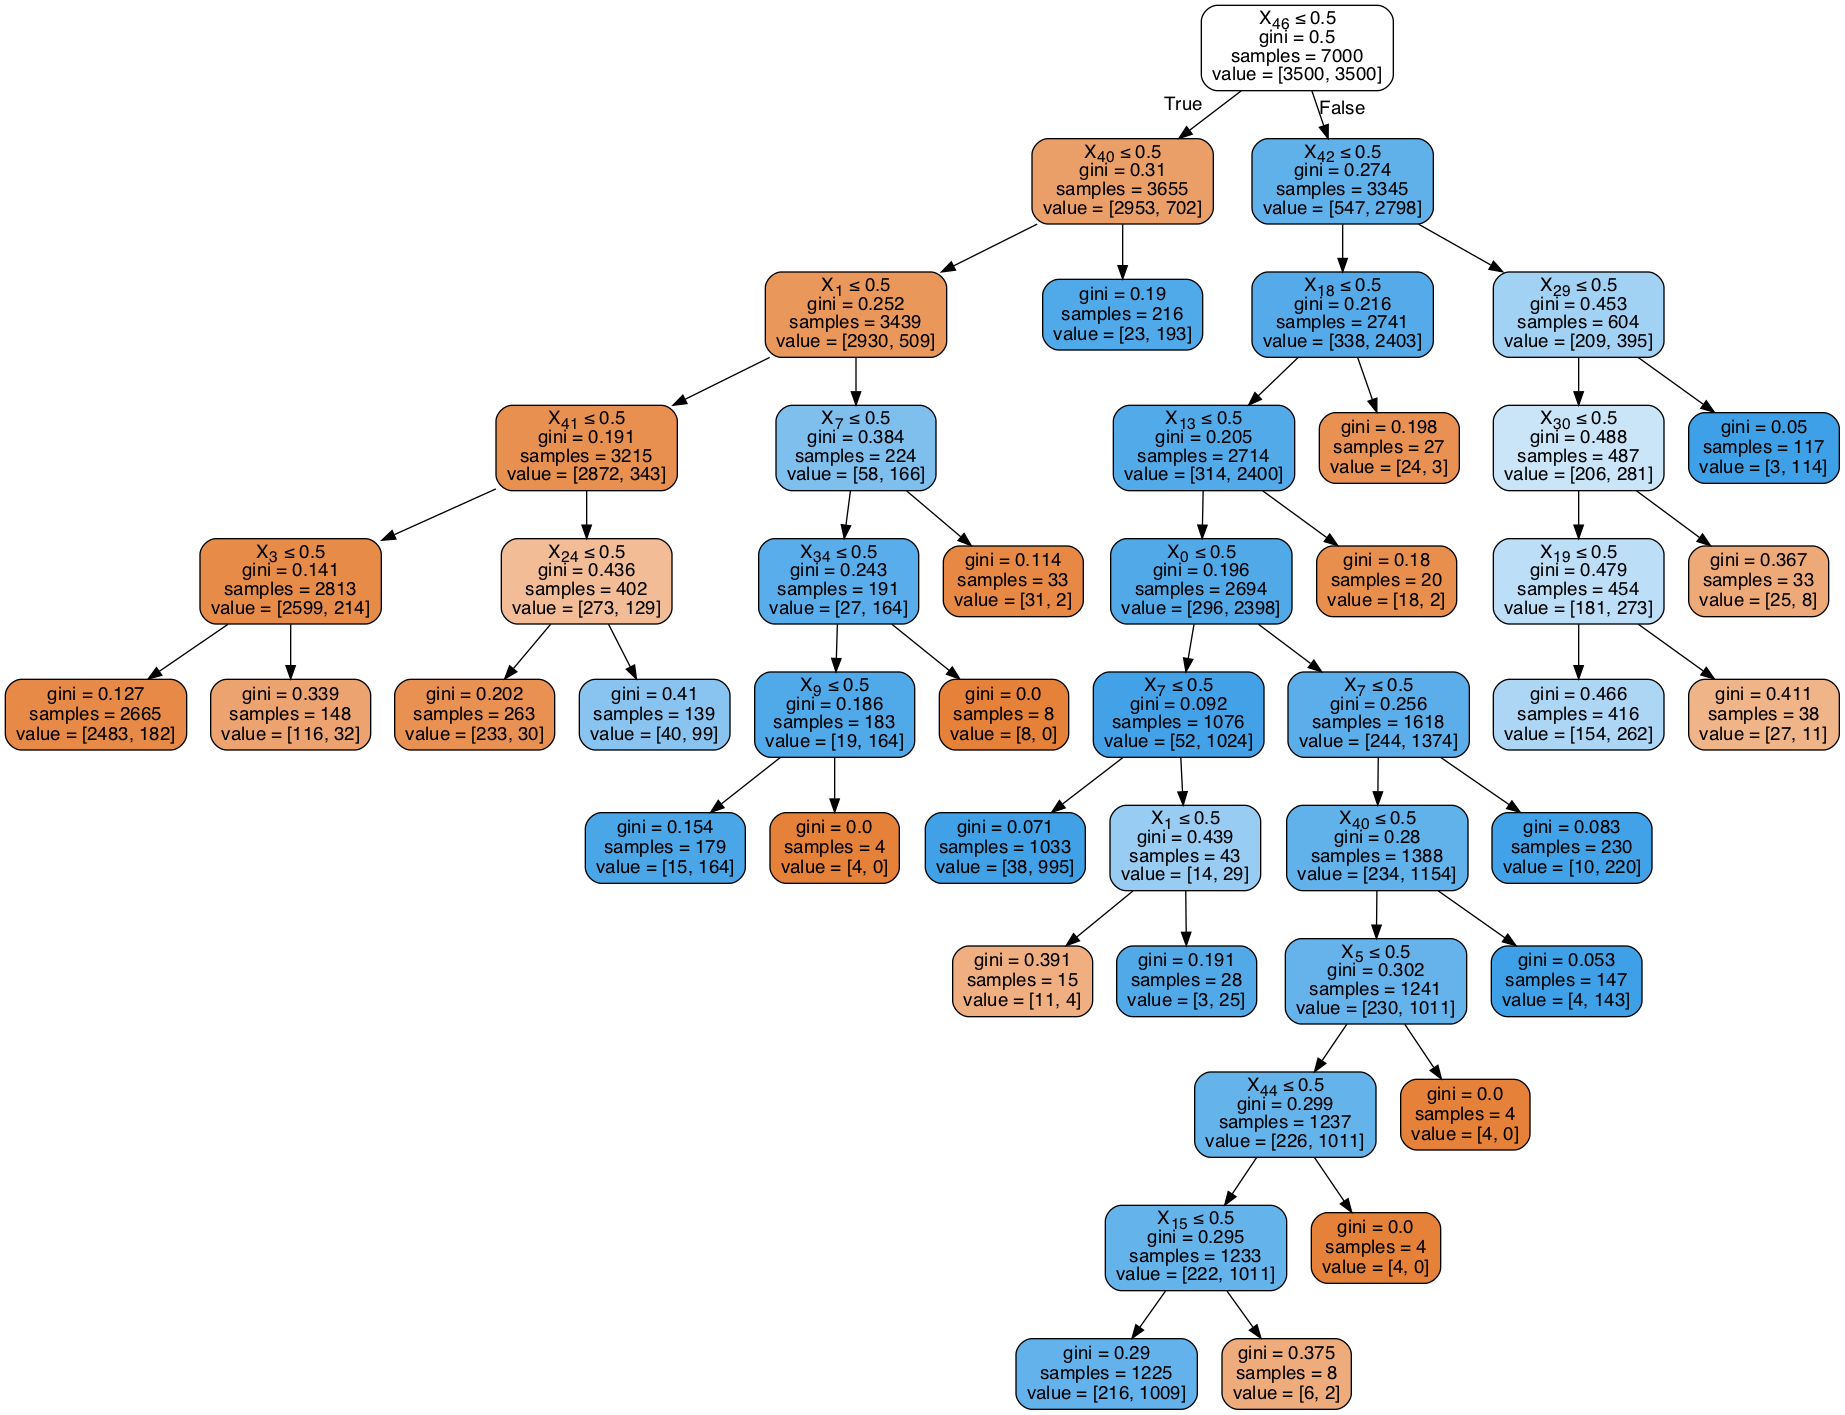

In [112]:
#Package for visualizing the decision tree
!pip install pydotplus

# Training a decision tree 

X_train, X_test, y_train, y_test = train_test_split(features, target, stratify=target, test_size=0.3,shuffle=True)

# TO be replaced by the best features of the xgboost model
cat_names = ['Covered_or_Noncovered_Indicator_1',
            'Related_Product_Indicator',
            'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State',
             'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1',
             'Form_of_Payment_or_Transfer_of_Value'
            ]
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),
                    ('scaler', StandardScaler())])

#Build a pipeline to handle the categorical features
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                       ('onehot',OneHotEncoder(handle_unknown='ignore'))])

#Build a column transformer to apply transformers above to given dataset
preprocessor = ColumnTransformer(
    transformers=[('cat', categorical_transformer, cat_names)])

X_train_processed = preprocessor.fit_transform(X_train[cat_names])
dtree=DecisionTreeClassifier(max_leaf_nodes=24)
dtree.fit(X_train_processed,y_train)

X_test_processed = preprocessor.transform(X_test[cat_names])
print('Decision Tree score',dtree.score(X_test_processed,y_test))

# Plotting the decision tree
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

We built a decision tree on the top 5 features according to XGBoost. This gives us a slightly better accuracy than the baseline model (at around 90%)